In [86]:
%%capture
import delfi.distribution as dd
import delfi.utils.io as io
import numpy as np
import pickle

import delfi.inference as infer
import delfi.generator as dg
from delfi.simulator import GaussMixture
import delfi.summarystats as ds

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.gridspec as gridspec

from parameters import ParameterSet
%run -i ../../DDELFI.py

import pickle

In [2]:
figs_dir = 'figs/'
output_dir = 'results/'

In [141]:
params = ParameterSet({})

seed = 42

params.res = ParameterSet({})
params.res.reinit_weights = True
params.res.n_components = 1
params.res.n_hiddens = [ 20, 20 ]
params.res.svi = False

params.run = ParameterSet({})
params.run.n_train = 3000
params.run.minibatch = 100
params.n_gradients = 100000

params.model = ParameterSet({})

In [142]:
from lfimodels.glm.GLM import GLM
from lfimodels.glm.GLMStats import GLMStats
import lfimodels.glm.utils as utils

params.model.prior_bounds = (-5, 5)
params.model.duration = 100
params.model.len_filter = 5

samples = None

output_prefix = 'glm_{}d'.format(params.model.len_filter + 1)

def sample_gt(seed, params):
    p = utils.smoothing_prior(n_params=params.model.len_filter+1, seed=seed)
    
    true_params, labels_params = utils.obs_params(len_filter=params.model.len_filter)
    obs_data = utils.obs_data(true_params, duration=params.model.duration, seed=seed)
    
    ret = utils.pg_mcmc(true_params, obs_data, duration=params.model.duration, seed=seed, prior_dist = p)
    return ret
    
def create_model(seed, params):
    m = GLM(params.model.duration, params.model.len_filter, seed=seed)
    ndim = m.n_params
    
    p = utils.smoothing_prior(n_params=params.model.len_filter+1, seed=seed)

    s = GLMStats(n_summary=ndim, seed=seed)

    g = dg.Default(model=m, prior=p, summary=s, seed=seed)
     
    true_params, labels_params = utils.obs_params(len_filter=params.model.len_filter)
    obs = utils.obs_stats(true_params, duration=params.model.duration, seed=seed)
    
    p_true = None
    
    if samples is not None:
        sample_mean = np.mean(samples, axis=1)
        sample_var = np.var(samples, axis=1)
        
        p_true = dd.Gaussian(m=sample_mean, S=np.diag(sample_var))

    return ParameterSet({ 'ndim' : ndim, 
                          'g' : g, 
                          'true_params' : true_params, 
                          'obs' : obs, 
                          'p_true' : p_true })

In [143]:
resample = False

samples_filename = output_dir + '/' + output_prefix + '_samples.npz'

try:
    assert not resample
    data = np.load(samples_filename)
    samples = data['samples']
except:
    samples = sample_gt(seed, params)
    np.savez(samples_filename, samples=samples)

In [144]:
def run_algo(algo, proposal, seed, params):
    model = create_model(seed, params)
    
    res_kwargs = {'generator': model.g, 
                  'reg_lambda': 0.01,
                  'verbose' : True,
                  'obs': model.obs.copy(),
                  'seed': seed}

    res_kwargs.update(params.res)
    
    cbk_feature_layer=0
    
    round_cl=999
    minibatch=100
    epochs = [params.n_gradients // (params.run.n_train//minibatch)]
    
    optim_data = None
    
    if algo == 'CDELFI':
        inf = infer.CDELFI(**res_kwargs)
        log, train_data, posteriors = inf.run(n_rounds=1,
                                              impute_proposal=proposal,
                                              epochs=epochs,
                                              **params.run)
    elif algo == 'SNPE':
        inf = infer.SNPE(**res_kwargs)
        log, train_data, posteriors = inf.run(n_rounds=1,
                                              impute_proposal=proposal,
                                              epochs=epochs,
                                              **params.run)     
    elif algo == 'kSNPE':
        inf = infer.SNPE(**res_kwargs)
        log, train_data, posteriors = inf.run(n_rounds=1,
                                              impute_proposal=proposal,
                                              epochs=epochs,
                                              kernel_loss='x_kl', 
                                              cbk_feature_layer=cbk_feature_layer,
                                              **params.run)
    elif algo == 'DDELFI':
        inf = DDELFI(**res_kwargs)
        log, train_data, posteriors, optim_data = inf.run(n_rounds=1,
                                                          impute_proposal=proposal,
                                                          epochs=epochs,
                                                          mog_nsamples=1e7,
                                                          **params.run)   
    else:
        raise ValueError("Unknown algorithm '{}'".format(algo))
    
    return {'algo': algo,
            'seed': seed,
            'model': model,
            'log': log,
            'impute_proposal' : proposal,
            'train_data': train_data,
            'posteriors': posteriors,
            'network' : inf.network,
            'stats_std' : inf.stats_std,
            'stats_mean' : inf.stats_mean,
            'optim_data' : optim_data,
            'cbk_feature_layer' : cbk_feature_layer
           }

In [145]:
#T_dofs = [ 1, 2, 3, 5, 10 ]
#alphas = [ 0.01, 0.1, 0.2, 0.3, 0.5, 0.8, 1.0 ]

T_dofs = []
alphas = []

def create_proposals(seed, params):
    model  = create_model(seed, params)
    prior = model.g.prior
    
    prop_Ts = { "Student's T (df = {})".format(dofs) : p_true.convert_to_T(dofs) for dofs in T_dofs }
    prop_alphas = { "Defensive (a = {})".format(alpha) : DefensiveDistribution(model.p_true, prior, alpha) for alpha in alphas }
    
    #post_std = np.diag(p_true.std)
    #post_m = p_true.mean
    
    #p_gauss = dd.Gaussian(m=post_m, S=post_std)
    ret = { "Prior" : prior, "Posterior" : model.p_true }#, "Gaussian Posterior" : p_gauss }
    ret.update(prop_Ts)
    ret.update(prop_alphas)
    return ret

In [147]:
proposals = create_proposals(seed, params)
algos = [ 'SNPE', 'kSNPE' ]#, 'DDELFI' ]
seeds = range(97,117)

outs = { algo : { proposal : [] for proposal in proposals } for algo in algos }

for seed in seeds:
    for algo in algos:
        for proposal_name in proposals:
            print("Seed: {}".format(seed))
            print("Algorithm: {}".format(algo))
            print("Proposal Prior: {}".format(proposal_name))
            proposal = proposals[proposal_name]
            out = run_algo(algo, proposal, seed, params)
            outs[algo][proposal_name].append(out)

Seed: 97
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 97
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 97
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 97
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 98
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 98
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 98
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 98
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 99
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 99
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 99
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 99
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 100
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 100
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 100
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 100
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 101
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 101
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 101
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 101
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 102
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 102
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 102
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 102
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 103
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 103
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 103
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 103
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 104
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 104
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 104
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 104
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 105
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 105
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 105
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 105
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 106
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 106
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 106
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 106
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 107
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 107
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 107
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 107
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 108
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 108
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 108
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 108
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 109
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 109
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 109
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 109
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 110
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 110
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 110
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 110
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 111
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 111
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 111
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 111
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 112
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 112
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 112
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 112
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 113
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 113
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 113
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 113
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 114
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 114
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 114
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 114
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 115
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 115
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 115
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 115
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 116
Algorithm: SNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 116
Algorithm: SNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


Seed: 116
Algorithm: kSNPE
Proposal Prior: Prior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget


Seed: 116
Algorithm: kSNPE
Proposal Prior: Posterior


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


fitting calibration kernel ...
done.


A Jupyter Widget

In [148]:
data_filename = output_dir + '/' + output_prefix + '.pkl'

with open(data_filename, 'wb') as of:
    pickle.dump(out, of)

In [151]:
def plot_marginal(ax, posteriors, label, ii, lims, c=None, alpha=0.3, p_true=None, proposal=None, title=None, gt=None, legend=True):
    if title is not None:
        ax.set_title(title)
        
    xlist = np.linspace(*lims, 400).reshape(-1,1)

    for posterior in posteriors:
        plt.plot(xlist.reshape(-1), posterior.eval(xlist, ii=ii, log=False), c, alpha=alpha, linewidth=2, label=label)
        label = None

    if p_true is not None:
        ax.plot(xlist.reshape(-1), p_true.eval(xlist, ii=ii, log=False), 'k', linewidth=2, label="GT")
        
    if proposal is not None:
        ax.plot(xlist.reshape(-1), proposal.eval(xlist, ii=ii, log=False), 'r', ls='--', alpha=0.6, linewidth=2, label="Proposal")

    ax.set_xlim(lims)
    ax.set_yticks([])

    if gt is not None:
        ax.axvline(gt[ii], c='r', linewidth=1.0)
        
    if legend:
        plt.legend()
        
    plt.tick_params(top='off', left='off', right='off', labelleft='off', labelbottom='on')

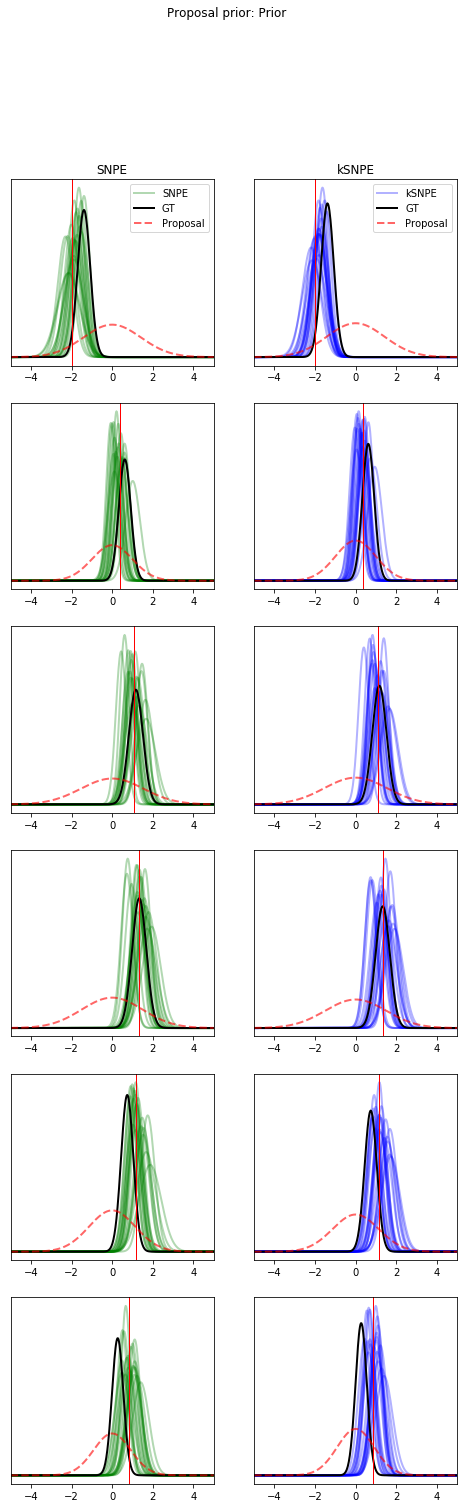

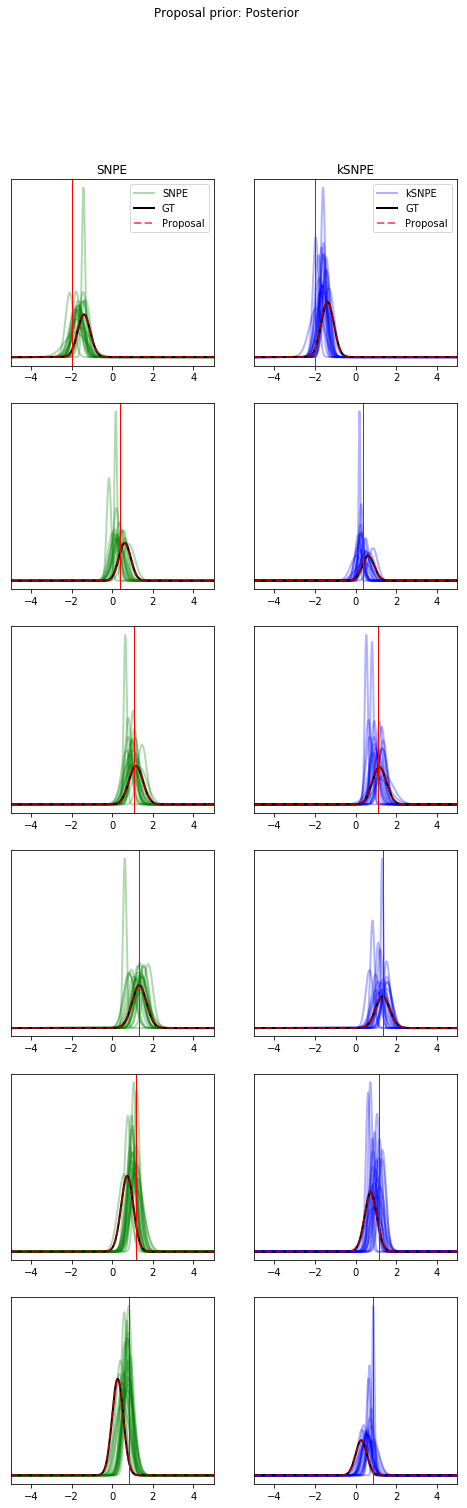

In [152]:
model = create_model(seed=None, params=params)
COL = { 'DDELFI' : 'orange', 'SNPE' : 'green', 'kSNPE' : 'blue' }

proposals = create_proposals(seed, params)

pdf_filename = "{}/{}.pdf".format(figs_dir, output_prefix)

box_size = (4, 4 * model.ndim)
with PdfPages(pdf_filename) as pdf:
    for proposal_name in proposals:
        gs = gridspec.GridSpec(1, len(algos))
        
        proposal = proposals[proposal_name]
        plt.figure(figsize=(box_size[0] * len(algos),box_size[1]))

        title = "Proposal prior: {}".format(proposal_name)
        xlist = np.linspace(*params.model.prior_bounds, 200).reshape(-1,1)
        plt.suptitle(title)
        
        for i, algo in enumerate(algos):  
            gs_algo = gridspec.GridSpecFromSubplotSpec(model.ndim, 1, gs[0,i])      
            posteriors = [ out['posteriors'][-1] for out in outs[algo][proposal_name] ]
    
            for j in range(model.ndim):
                ax = plt.subplot(gs_algo[j,0])

                plot_marginal(ax,
                              posteriors, 
                              algo,
                              ii=[j], 
                              lims=params.model.prior_bounds,
                              c=COL[algo],
                              p_true=model.p_true, 
                              proposal=proposal, 
                              title=algo if j == 0 else None,
                              gt=model.true_params,
                              legend=(j == 0))

            #weights = model.g.prior.eval(xlist, [j], log=False) / proposal.eval(xlist, [j], log=False)
            #weights /= np.interp([0], xlist.reshape(-1), weights)

            #ax = plt.subplot(model.ndim + 1, len(algos) + 1, len(algos)+1 + j * (len(algos) + 1))

            #if j == 0:
            #    ax.set_title("Normalised Importance Weights")

            #xlist = np.linspace(-10, 10, 200).reshape(-1,1)

            #plt.semilogy(xlist.reshape(-1), p_true.eval(xlist, log=False), 'k', linewidth=2, label="GT")
            #plt.semilogy(xlist.reshape(-1), proposal.eval(xlist, log=False), 'r', ls='--', alpha=0.6, linewidth=2, label="Proposal")

            #plt.semilogy(xlist.reshape(-1), weights, 'magenta', ls='--', alpha=0.6, linewidth=2, 
            #             label="Weights")

            #plt.xlim((-10, 10))

            #plt.legend()
            #plt.tick_params(top='off', left='off', right='off', labelright='off', labelleft='on', labelbottom='on')

        pdf.savefig()
        plt.show()